# Snapshotting

### Replica


In [1]:
from utils import run, run2
import seaborn as sns

from distributions import Uniform, Zipfian, HotSet
from kevo import LSMTree, AppendLog, HybridLog, MemOnly, PathReplica

In [5]:
base_dir = './benchmark_data_'
replica = PathReplica(base_dir + LSMTree.name, '/tmp/remote')
replica2 = PathReplica(base_dir + HybridLog.name, '/tmp/remote')
replica3 = PathReplica(base_dir + AppendLog.name, '/tmp/remote')
df = run(
    [4], [4], [100_000], list(range(10_000, 100_000, 10_000)),
    [Uniform], [{'seed': [1]}],
    [LSMTree, HybridLog, AppendLog], [
        {
            'max_runs_per_level': [3],
            'density_factor': [10],
            'memtable_bytes_limit': [1_000],
            'replica': [None, replica]
        },
        {
            'max_runs_per_level': [3],
            'mem_segment_len': [1_000],
            'ro_lag_interval': [100],
            'flush_interval': [100],
            'hash_index': ['dict'],
            'compaction_enabled': [False],
            'replica': [None, replica2]
        },
        {
            'max_runs_per_level': [3],
            'threshold': [1_000],
            'replica': [None, replica3]
        }
    ],
    times=1, base_dir=base_dir,
    measure_cpu=False, measure_mem=False, measure_write=True,
    measure_read=True, measure_recovery=True, measure_disk_local=True,
    measure_disk_remote=True,
    return_df=True
)

In [3]:
def relplot(cat, engine, x, y, col, data, hue=None, style=None, X='', Y='', title='', ylim=None):
    data = data[data['metric'].isin(y)]
    plot = sns.relplot(data=data, x=x, y='value', col=col, hue=hue, style=style, kind='line')
    if title:
        plot.fig.subplots_adjust(top=0.9)
        plot.fig.suptitle(f'{Y} vs {X}')
    if X:
        plot.set_xlabels(X)
    if Y:
        plot.set_ylabels(Y)
    if ylim is not None:
        plot.set(ylim=ylim)
    plot.savefig(f"{cat}-{engine}-{'_'.join(y)}-{col}-vs-{x}.png")

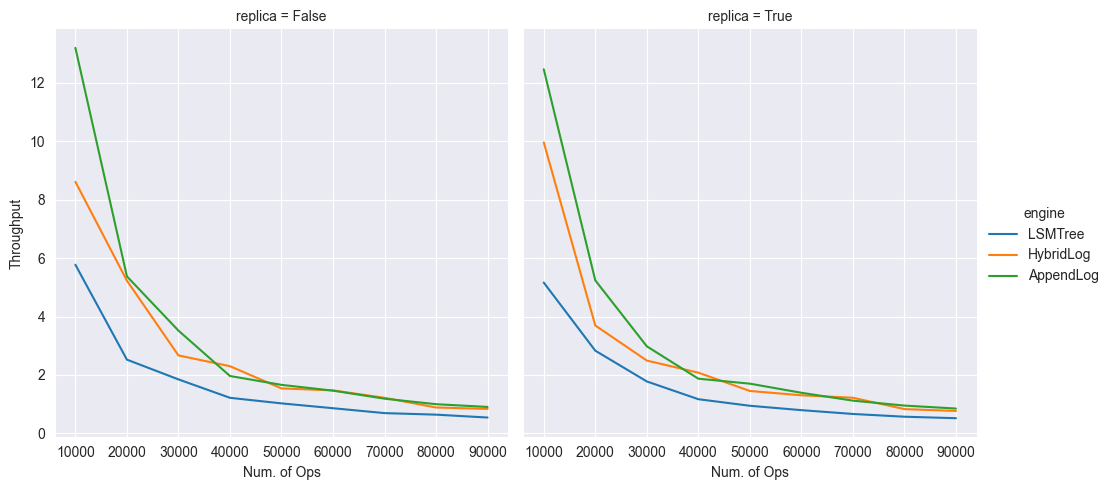

In [6]:
relplot(
    'C', 'ALL',
    'n_ops', ['write_t'], 'replica',
    df[['value', 'n_ops', 'metric', 'engine', 'replica']],
    hue='engine', style=None,
    X='Num. of Ops', Y='Throughput',
)

In [4]:
def lineplot(cat, engine, x, y, data, hue=None, style=None, X='', Y='', title='', ylim=None):
    data = data[data['metric'].isin(y)]
    plot = sns.lineplot(data=data, x=x, y='value', hue=hue, style=style)
    if title:
        plot.set_title(f'{Y} vs {X}')
    if X:
        plot.set_xlabel(X)
    if Y:
        plot.set_ylabel(Y)
    if ylim is not None:
        plot.set(ylim=ylim)
    fig = plot.get_figure()
    fig.savefig(f"{cat}-{engine}-{'_'.join(y)}-vs-{x}.png")

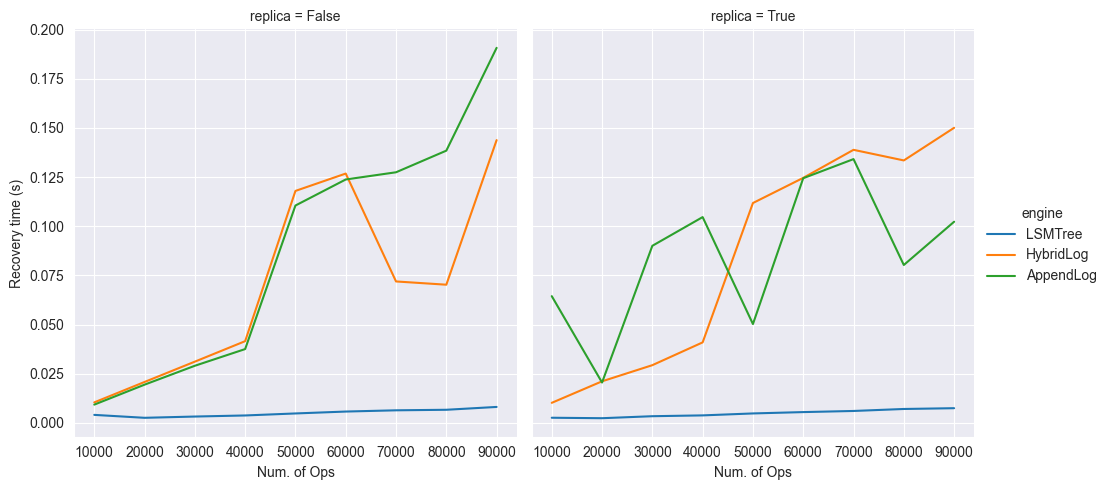

In [7]:
relplot(
    'C', 'LSM',
    'n_ops', ['recovery'], 'replica',
    df[['value', 'n_ops', 'engine', 'metric', 'replica']],
    hue='engine', style=None,
    X='Num. of Ops', Y='Recovery time (s)',
)

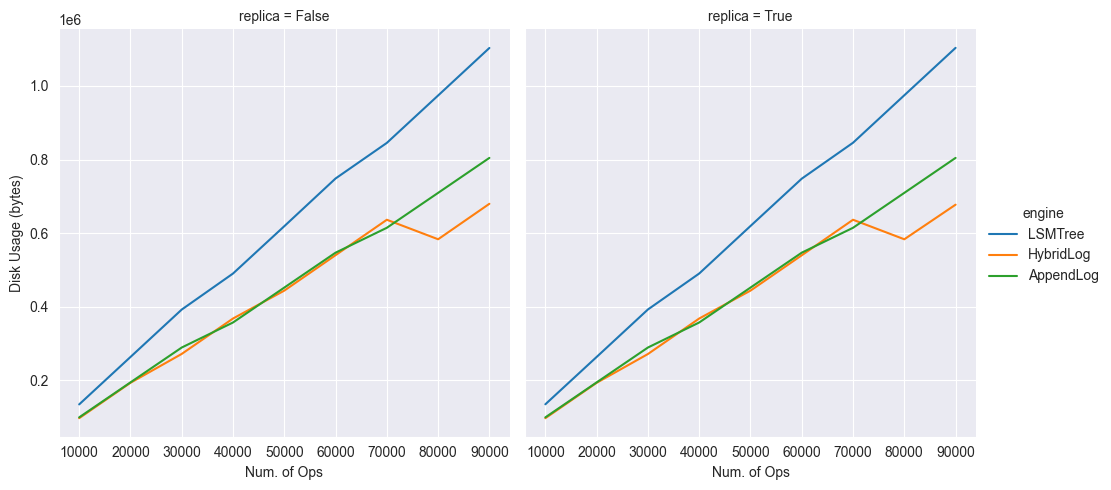

In [10]:
relplot(
    'C', 'LSM',
    'n_ops', ['disk_local'], 'replica',
    df[['value', 'n_ops', 'metric', 'engine', 'replica']],
    hue='engine', style=None,
    X='Num. of Ops', Y='Disk Usage (bytes)',
)

### Disk growth vs time

In [24]:
base_dir = './benchmark_data_'
replica = PathReplica(base_dir + LSMTree.name, '/tmp/remote')
replica2 = PathReplica(base_dir + HybridLog.name, '/tmp/remote')
replica3 = PathReplica(base_dir + AppendLog.name, '/tmp/remote')
df = run2(
    [4], [4], [10_000], [10_000],
    [Uniform], [{'seed': [1]}],
    [LSMTree, HybridLog, AppendLog], [
        {
            'max_runs_per_level': [3],
            'density_factor': [10],
            'memtable_bytes_limit': [1_000],
            'replica': [replica]
        },
        {
            'max_runs_per_level': [3],
            'mem_segment_len': [1_000],
            'ro_lag_interval': [100],
            'flush_interval': [100],
            'hash_index': ['dict'],
            'compaction_enabled': [False],
            'replica': [replica2]
        },
        {
            'max_runs_per_level': [3],
            'threshold': [1_000],
            'replica': [replica3]
        }
    ],
    times=1, base_dir=base_dir, measure_write=True,
    measure_disk_local=True, measure_disk_remote=True,
    return_df=True
)

In [8]:
def lineplot(cat, engine, x, y, data, hue=None, style=None, X='', Y='', title='', ylim=None):
    data = data[data['metric'].isin(y)]
    plot = sns.lineplot(data=data, x=x, y='value', hue=hue, style=style)
    if title:
        plot.set_title(f'{Y} vs {X}')
    if X:
        plot.set_xlabel(X)
    if Y:
        plot.set_ylabel(Y)
    if ylim is not None:
        plot.set(ylim=ylim)
    fig = plot.get_figure()
    fig.savefig(f"{cat}-{engine}-{'_'.join(y)}-vs-{x}.png")


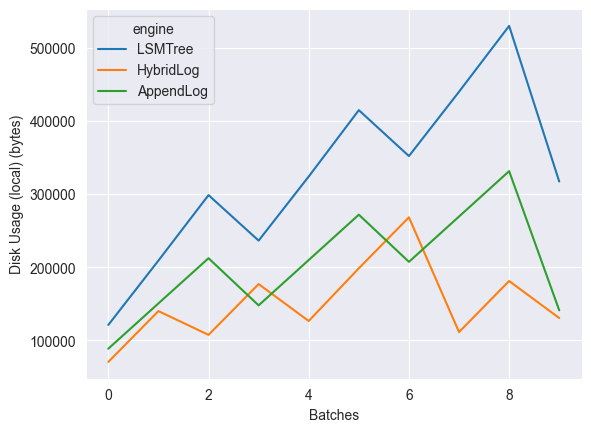

In [28]:
lineplot(
    'C', 'ALL',
    'inc', ['disk_local'],
    df[['value', 'inc', 'metric', 'engine']],
    'engine', None,
    'Batches', 'Disk Usage (local) (bytes)'
)

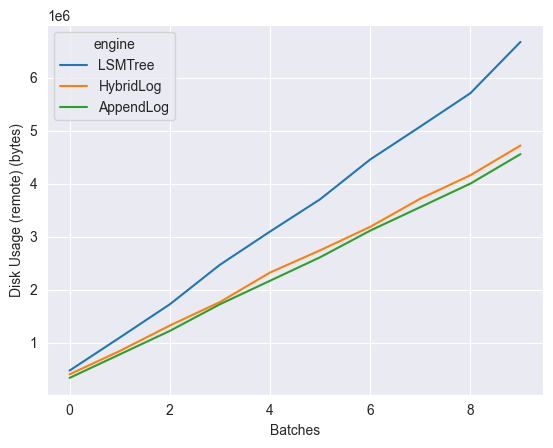

In [29]:
lineplot(
    'C', 'ALL',
    'inc', ['disk_remote'],
    df[['value', 'inc', 'metric', 'engine']],
    'engine', None,
    'Batches', 'Disk Usage (remote) (bytes)'
)